In [2]:
import pandas as pd
import numpy as np
%matplotlib inline

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('../Data/co2_mm_mlo.csv')

In [5]:
df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


In [6]:
df['date'] = pd.to_datetime(dict(year=df['year'], month=df['month'], day=1))
df.set_index(df['date'], inplace=True)
df.index.freq = 'MS'
df.head()

,year,month,decimal_date,average,interpolated,date
date,,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71,1958-03-01
1958-04-01,1958,4,1958.292,317.45,317.45,1958-04-01
1958-05-01,1958,5,1958.375,317.50,317.50,1958-05-01
1958-06-01,1958,6,1958.458,NaN,317.10,1958-06-01
1958-07-01,1958,7,1958.542,315.86,315.86,1958-07-01


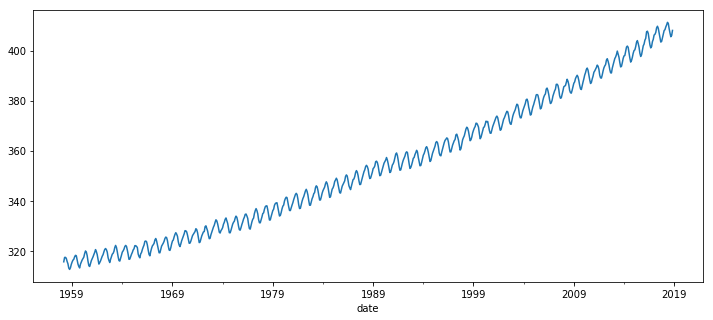

In [8]:
df['interpolated'].plot(figsize=(12, 5))

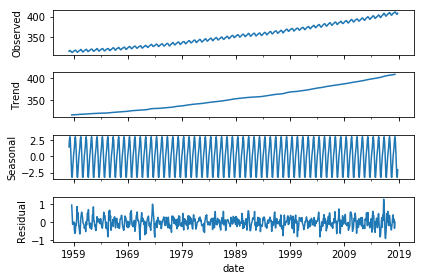

In [10]:
# ETS Decomposition
result = seasonal_decompose(df['interpolated'], model='add')
result.plot();

#### obtain orders

In [11]:
auto_arima(df['interpolated'], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  729
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -207.462
Date:                            Sun, 28 Aug 2022   AIC                            424.925
Time:                                    17:16:47   BIC                            447.876
Sample:                                         0   HQIC                           433.781
                                            - 729                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.001      1.044      0.296      -0.001       0.002
ma.L1         -0.3803      0.034    -11.130      0.000      -0.447      -0.313
ar.S.L12       0.9995      0.000   3054.231      0.000       0.999       1.000
ma.S.L12      -0.8631      0.022    -39.883      0.000      -0.906      -0.821
sigma2         0.0964      0.005     20.353      0.000       0.087       0.106
===================================================================================
Ljung-Box (Q):                       52.16   Jarque-Bera (JB):                 3.68
Prob(Q):                              0.09   Prob(JB):                         0.16
Heteroskedasticity (H):               1.11   Skew:                            -0.04
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
len(df)

729

In [13]:
# train-test split
train = df.iloc[:717]
test = df.iloc[717:]

#### Fit and Predict

In [14]:
model = SARIMAX(train['interpolated'], order=(0,1,1), seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                       interpolated   No. Observations:                  717
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -205.149
Date:                            Sun, 28 Aug 2022   AIC                            418.298
Time:                                    17:19:05   BIC                            436.593
Sample:                                03-01-1958   HQIC                           425.363
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3702      0.034    -10.796      0.000      -0.437      -0.303
ar.S.L12       0.9997      0.000   3173.007      0.000       0.999       1.000
ma.S.L12      -0.8648      0.023    -37.719      0.000      -0.910      -0.820
sigma2         0.0959      0.005     20.279      0.000       0.087       0.105
===================================================================================
Ljung-Box (Q):                       52.01   Jarque-Bera (JB):                 3.77
Prob(Q):                              0.10   Prob(JB):                         0.15
Heteroskedasticity (H):               1.13   Skew:                            -0.02
Prob(H) (two-sided):                  0.36   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
start = len(train)
end = start + len(test) - 1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,1)(1,0,1,12) PREDICTIONS')

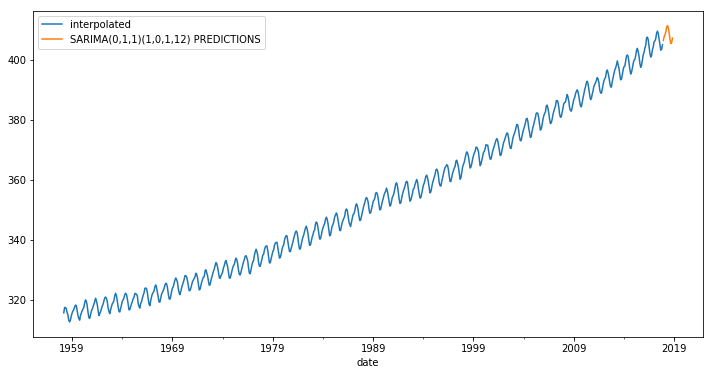

In [28]:
train['interpolated'].plot(figsize=(12, 6), legend=True)
predictions.plot(legend=True)

#### Evaluate Model

In [17]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

In [18]:
mse_error = mean_squared_error(test['interpolated'], predictions)
rmse_error = rmse(test['interpolated'], predictions)

print(f'mse error: {mse_error}')
print(f'rmse error: {rmse_error}')

mse error: 0.11981936683819339
rmse error: 0.34614934181389595


#### Retrain on full data and Forecast

In [29]:
df.head()

,year,month,decimal_date,average,interpolated,date
date,,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71,1958-03-01
1958-04-01,1958,4,1958.292,317.45,317.45,1958-04-01
1958-05-01,1958,5,1958.375,317.50,317.50,1958-05-01
1958-06-01,1958,6,1958.458,NaN,317.10,1958-06-01
1958-07-01,1958,7,1958.542,315.86,315.86,1958-07-01


In [31]:
auto_arima(df['interpolated'], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  729
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -207.462
Date:                            Sun, 28 Aug 2022   AIC                            424.925
Time:                                    17:34:55   BIC                            447.876
Sample:                                         0   HQIC                           433.781
                                            - 729                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.001      1.044      0.296      -0.001       0.002
ma.L1         -0.3803      0.034    -11.130      0.000      -0.447      -0.313
ar.S.L12       0.9995      0.000   3054.231      0.000       0.999       1.000
ma.S.L12      -0.8631      0.022    -39.883      0.000      -0.906      -0.821
sigma2         0.0964      0.005     20.353      0.000       0.087       0.106
===================================================================================
Ljung-Box (Q):                       52.16   Jarque-Bera (JB):                 3.68
Prob(Q):                              0.09   Prob(JB):                         0.16
Heteroskedasticity (H):               1.11   Skew:                            -0.04
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [59]:
model = SARIMAX(df['interpolated'],order=(0,1,1),seasonal_order=(1,0,1,12))
results = model.fit()
forecast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA(0,1,3)(1,0,1,12) Forecast')

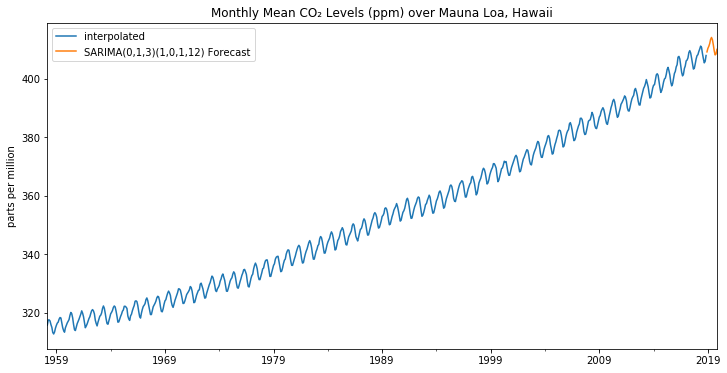

In [60]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = df['interpolated'].plot(legend=True,figsize=(12,6),title=title)
forecast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);